# Artificial Intelligence
## Image Generator

OpenAI Dall-E (and others) are text-to-image models developed by OpenAI using deep learning methodologies to generate digital images from natural language descriptions, called "prompts".

Reference:

+ https://gemini.google.com/app
  + https://cloud.google.com/vertex-ai/generative-ai/docs/image/img-gen-prompt-guide
  + https://tech.co/news/use-google-bard-ai-image-generator
+ https://www.midjourney.com/explore?tab=top

+ https://openai.com/index/dall-e-2/

+ https://builtin.com/artificial-intelligence/prompt-engineering

+ https://flux-ai.io/

In [1]:
BUCKET_NAME ="cio-training-vertex-colab"
PROJECT_ID  ="usfs-ai-bootcamp"
LOCATION    ="us-central1"

In [2]:
#import minimal libraries to support installation of additional tools
import sys
import subprocess
import importlib.util

## Environment Check

In [3]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#- Google Colab Check
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import datetime

RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())
current_time   = datetime.datetime.now()

if RunningInCOLAB:
    print(f"You are running this notebook in Google Colab at {current_time} in the {PROJECT_ID} lab.")
else:
    print(f"You are likely running this notebook with Jupyter iPython runtime at {current_time} in the {PROJECT_ID} lab.")

You are running this notebook in Google Colab at 2024-12-04 14:26:14.248182 in the usfs-ai-bootcamp lab.


# GCP Gemini Setup

In [4]:
#Download Google Vextex/AI Libraries
subprocess.run(["pip", "install" , "--upgrade", "google-cloud-aiplatform", "--quiet"])


libraries=["google-generativeai", "google-cloud-secret-manager", "openai"]

for library in libraries:
    spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"])
    else:
      print("Library " + library + " already installed.")

from google.cloud import aiplatform
import vertexai.preview
from google.cloud import secretmanager
import vertexai
import openai
from google.auth import default, transport

Installing library google-generativeai
Installing library google-cloud-secret-manager
Library openai already installed.


## Libraries

In [5]:
############################################
# INCLUDES
############################################
#libraries specific to this example
## Imports
#import tensorflow as tf
#from tensorflow import keras

from IPython import display

#a set of libraries that perhaps should always be in Python source
import os
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
import textwrap
import random
import glob
import os
import PIL
import time
import subprocess

#images
import imageio
import matplotlib as matplt
import matplotlib.pyplot as plt

#data science
import numpy as np

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

from pydoc import help                          # can type in the python console `help(name of function)` to get the documentation

warnings.filterwarnings('ignore')               # don't print out warnings

## Variables

In [6]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "MLGENIMG"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"

############################################
# GLOBAL CONSTANTS
############################################
BUFFER_SIZE = 60000
BATCH_SIZE = 256
TEXT_WIDTH=77
############################################
# APPLICATION VARIABLES
############################################
start = "\033[1m"
end = "\033[0;0m"

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


## Function

In [7]:
## Outputs library version history of effort.
#
def lib_diagnostics() -> None:

    import pkg_resources

    package_name_length=40
    package_version_length=20

    # Get installed packages
    the_packages=["nltk", "numpy", "os", "pandas"]
    installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    for package_idx, package_name in enumerate(installed):
         if package_name in the_packages:
             installed_version = installed[package_name]
             print(f"{package_name:<40}#: {str(pkg_resources.parse_version(installed_version)):<20}")

    try:
        print(f"{'OpenAI version':<40}#: {str(openai.__version__):<20}")
    except Exception as e:
        pass


    try:
        print(f"{'TensorFlow version':<40}#: {str(tf.__version__):<20}")
        print(f"{'     gpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('GPU')))}")
        print(f"{'     cpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('CPU')))}")
    except Exception as e:
        pass

    try:
        print(f"{'Torch version':<40}#: {str(torch.__version__):<20}")
        print(f"{'     GPUs available?':<40}#: {torch.cuda.is_available()}")
        print(f"{'     count':<40}#: {torch.cuda.device_count()}")
        print(f"{'     current':<40}#: {torch.cuda.current_device()}")
    except Exception as e:
        pass

    try:
      print(f"{'GCP AI Platform version':<40}#: {str(aiplatform.__version__):<20}")
    except Exception as e:
      pass

    try:
      print(f"{'GCP Vertex version':<40}#: {str(vertexai.__version__):<20}")
    except Exception as e:
      pass

    try:
      print(f"{'Secret Manager version':<40}#: {str(secretmanager.__version__):<20}")
    except Exception as e:
      pass

    return

## Function Call

In [8]:
lib_diagnostics()
wrapper = textwrap.TextWrapper(width=TEXT_WIDTH)

nltk                                    #: 3.9.1               
numpy                                   #: 1.26.4              
pandas                                  #: 2.2.2               
OpenAI version                          #: 1.54.3              
GCP AI Platform version                 #: 1.73.0              
GCP Vertex version                      #: 1.73.0              
Secret Manager version                  #: 2.21.1              


## Model Parameters and Model Selection

Imagen 2 for Generation and Editing brings Google's advanced text-to-image technology to application developers. Imagen 2 boasts a variety of image generation features to help organizations create images that match their specific brand requirements with the same enterprise-grade reliability and governance you're used to with Imagen.

With Imagen 2 for Generation and Editing, you can use text prompts to generate novel images or edit existing ones, or edit only parts of images using a mask.

Image generation is delivered by model versions @006 (default) and @005.
Mask-based image editing works best using model version @006 (@002 also supports it).
Mask-free image editing is available by using model version @002.
Supported languages for text prompts in Imagen 2 Generation include English, Chinese, Hindi, Japanese, Korean, Portuguese, and Spanish.

Use cases
+ Generate images: Enter text prompts to generate a series of images. For example, "A French cafe with the Golden Gate Bridge in the background."

+ Edit images: Edit images with built-in segmentation features that enable you to segment the image’s background, foreground, or ~175 subject classes

+ Product editing: Provide an image of a product and a text prompt describing a new scenery to easily enhance product images
+ Inpainting (removal): Provide an image and a mask that highlights a subject that you want to remove from the image

+ Inpainting (insert): Provide an image and a mask to insert a subject based on your input text prompt
Outpainting: Provide an image and a mask to extend the image to a custom size that you desire



In [9]:
###########################################
#- API Parameters for things like WordCloud
#- Variables help hold information for later use
#- The "constants" represent variables that we don't anticipate changing over the course of the program.
###########################################
#model parameters
#changing the model can influence the type of response you get at the end.

#AVAILABLE MODELS - https://firebase.google.com/docs/vertex-ai/gemini-models
#GCP LLM Info     - https://cloud.google.com/ai/llms?hl=en
#Gemini 1.5 Flash	google/gemini-1.5-flash-001
#Gemini 1.5 Prov	google/gemini-1.5-pro-001
#Gemini 1.0 Prov	google/gemini-1.0-pro-002
#                   google/gemini-1.0-pro-001
#                   google/gemini-1.0-pro
# Select ai model type, for detailed information about each model see: https://firebase.google.com/docs/vertex-ai/gemini-models#detailed-info
# Model names for Gemini, see: https://firebase.google.com/docs/vertex-ai/gemini-models#available-model-names
# All model reference, see: https://cloud.google.com/vertex-ai/generative-ai/docs/model-garden/explore-models
# Image Model Developer's Guide, see: https://cloud.google.com/blog/products/ai-machine-learning/a-developers-guide-to-imagen-3-on-vertex-ai?e=0?utm_source%3Dlinkedin
# Example Notebook, see: https://github.com/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/imagen3_image_generation.ipynb

AI_MODEL_TYPE = "imagegeneration@006"
AI_MODEL_TYPE = "imagen-3.0-generate-001"

model_temperature=0.5                     #Model temperature is a parameter that controls the randomness and creativity of a language model's output.
                                          #It's a key factor in the quality of the text generated by the model, and is used in many natural language processing (NLP) tasks,
                                          #such as summarization, translation, and text generation.

model_max_tokens=8000                     #Model max tokens refers to the maximum number of tokens a language model can process in a single input, including both the prompt
                                          #provided and the generated output, essentially setting the upper limit on the length of the text the model can generate in a single
                                          #response; exceeding this limit will result in the model truncating the output or potentially returning an error message

model_max_token_response=8000             #Maximum reponse you're preparing to return with, sets limits for future calculations.

model_top_p=1                             #Top P specifies the cumulative probability score threshold that the tokens must reach.
                                          #For example, if you set Top P to 0.6, then only the first two tokens, for and to, are sampled
                                          #because their probabilities (0.4 and 0.25) add up to 0.65.

model_top_k=1                             #Top-k sampling samples tokens with the highest probabilities until the specified number of
                                          #tokens is reached. Top-p sampling samples tokens with the highest probability scores until
                                          #the sum of the scores reaches the specified threshold value. (Top-p sampling is also called nucleus sampling.)

summary_token_max=150



# AI Filters

In [10]:
# import the required libraries
import vertexai
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Part,
    SafetySetting,
)

# safety settings

safety = [
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
]

## Large Language Model (LLM) ~ Gemini Visual Model (Google)

In [11]:
from vertexai.preview.vision_models import ImageGenerationModel

# Create the model
# See https://ai.google.dev/api/python/google/generativeai/GenerativeModel

try:
    model = ImageGenerationModel.from_pretrained(AI_MODEL_TYPE)
except (ValueError, Exception) as e:
    print("ERROR: Problem loading your image model, see the exception below, inspect your code and try again.")
    print(repr(e))

## Create Your Picture Prompt

In [21]:
#options for creating an image
style=["normal", "abstract", "surrealism", "cubism", "impressionism", "3d", "expressionist painting", "manga", "pop art", "pencil sketch", "watercolor"]
detail=["normal", "realistic", "ultrarealistic", "photorealistic", "photorealistic", "photorealistic", "photorealistic", "photorealistic", "photorealistic", "intricate", "highly detailed"]
position=["normal", "on the wall", "in the background", "in the foreground", "in the middle", "in the left", "in the right"]
mood=["normal", "stunning", "elegant", "radiant", "delicate", "cute", "striking" "glamorous"]
lights=["normal", "warm lighting", "natural lighting", "cold lighting", "dark aesthetic", "red tones", "blue tones"]
viewpoint=["portrait", "landscape", "close-up", "headshot", "mid-range", "3/4 shot", "full body shot", "wide shot", "low angle shot", "high angle shot"]

subject=["penguin", "bear", "tree", "dog", "cat", "plan", "spotted lantern fly", "eastern longhorn beetle"]

verb=["running", "surfing", "on the computer", "sleeping", "eating", "playing", "dancing", "sitting", "standing", "walking"]



#generate a picture from random choices above
picture_prompt=f"{style[random.randint(0, len(style)-1)]} \
 {detail[random.randint(0, len(detail)-1)]} \
 {position[random.randint(0, len(position)-1)]} \
 {mood[random.randint(0, len(mood)-1)]} \
 {lights[random.randint(0, len(lights)-1)]} \
 {viewpoint[random.randint(0, len(viewpoint)-1)]}\
 {subject[random.randint(0, len(subject)-1)]} \
 {verb[random.randint(0, len(verb)-1)]}"

#examples
#picture_prompt="magazine style, 4k, photorealistic, modern red armchair, natural"
#picture_prompt="hyper-realistic, 4k, bear smoking a cigar holding a tommy gun while standing surfing on a shark"


#format the output to make it legible
string = wrapper.fill(text=picture_prompt)
print(f"Random text created: {picture_prompt}")

#############################################################
# REPLACE picture_prompt with your own
# input if you want the image created to change
#############################################################


Random text created: abstract  photorealistic  in the background  stunning  red tones  close-up penguin  playing


## Execute the Image Generation

Your save location is ./output.png.
For prompt: abstract  photorealistic  in the background  stunning  red tones  close-up penguin  playing


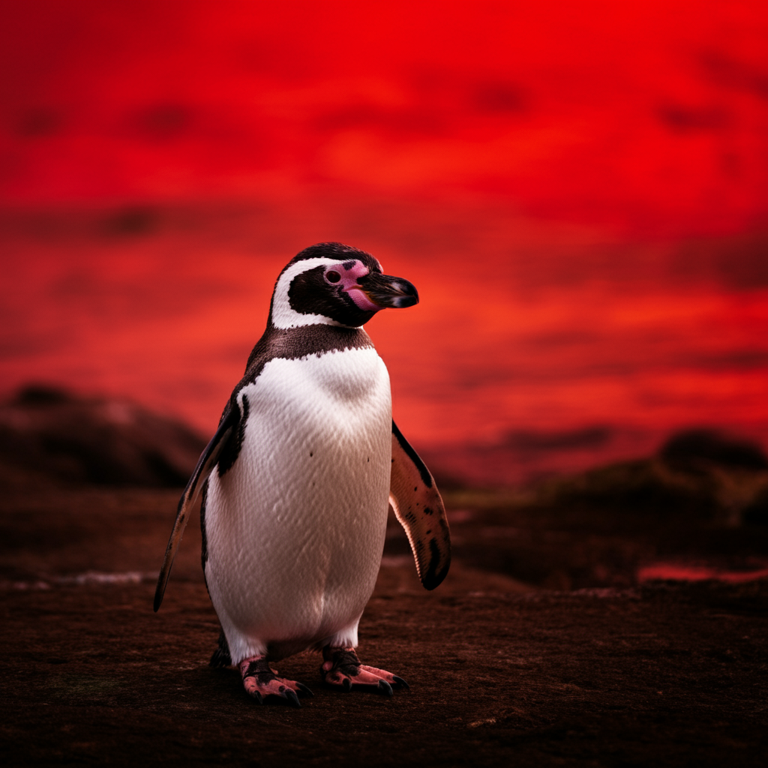

Created output image using 1194765 bytes


In [22]:
from PIL import Image
from IPython.display import display
try:
  images = model.generate_images(
      prompt=picture_prompt,

      # Optional parameters
      number_of_images=1,
      language="en",

      # You can't use a seed value and watermark at the same time.
      add_watermark=False,
      #seed=100,
      aspect_ratio="1:1",
      safety_filter_level="block_some",
      person_generation="allow_all",
  )

  try:
    output_file="./output.png"
    images[0].save(location=output_file, include_generation_parameters=False)
    print(f"Your save location is {output_file}.")
    print(f"For prompt: {picture_prompt}")
  except Exception as e:
    print("There was a problem saving your image.")
    print(f"{start}See exception:{end} ")
    string = wrapper.fill(text=str(e))
    print(string)
    print(f"Your save location was {output_file}.")

  # Optional. View the generated image in a notebook.
  try:
    #images[0].show(). #without modification to size (which is huge)
    image = Image.open(output_file)
    scale = 0.75
    display(image.resize(( int(image.width * scale), int(image.height * scale))))

    print(f"Created output image using {len(images[0]._image_bytes)} bytes")
  except Exception as e:
    print("There was a problem displaying your image.")
    print(f"{start}See exception:{end} ")
    string = wrapper.fill(text=str(e))
    print(string)

except Exception as e:
  print("There was a problem creating your image.")
  print("\n")
  print(f"{start}See exception:{end} ")
  string = wrapper.fill(text=str(e))
  print(string)
  print("\n")
  print(f"{start}Your prompt was:{end} ")
  string = wrapper.fill(text=picture_prompt)
  print(string)




# Do you understand the stochastic nature of AI?

Definition of stochastic: randomly determined; having a random probability distribution or pattern that may be analyzed statistically but may not be predicted precisely.

*** If this same prompt runs multiple times, do you expect to see the same picture every time....??? ***

Image Number: 0
Your save location is ./output_0.png.
For prompt: hyper-realistic, 4k, bear smoking a cigar holding a tommy gun while standing surfing a shark


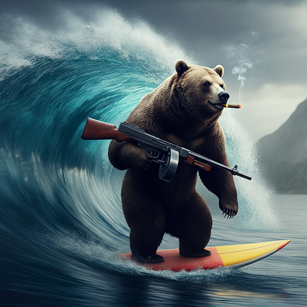

Created output image using 1692249 bytes



Image Number: 1
Your save location is ./output_1.png.
For prompt: hyper-realistic, 4k, bear smoking a cigar holding a tommy gun while standing surfing a shark


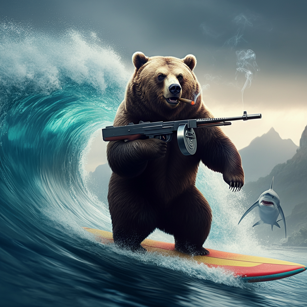

Created output image using 1668413 bytes





In [14]:
number_of_times=3
for index, value in enumerate(range(1,number_of_times)):

  try:
    images = model.generate_images(
        prompt=picture_prompt,

        # Optional parameters
        number_of_images=1,
        language="en",

        # You can't use a seed value and watermark at the same time.
        # add_watermark=False,
        # seed=100,
        aspect_ratio="1:1",
        safety_filter_level="block_some",
        person_generation="allow_adult",
    )

    try:
      output_file=f"./output_{str(index)}.png"
      images[0].save(location=output_file, include_generation_parameters=False)
      print(f"Image Number: {str(index)}")
      print(f"Your save location is {output_file}.")
      print(f"For prompt: {picture_prompt}")
    except Exception as e:
      print("There was a problem saving your image.")
      print(f"{start}See exception:{end} ")
      string = wrapper.fill(text=str(e))
      print(string)
      print(f"Your save location was {output_file}.")

    # Optional. View the generated image in a notebook.
    try:
      #images[0].show(). #without modification to size (which is huge)
      image = Image.open(output_file)
      scale = 0.3
      display(image.resize(( int(image.width * scale), int(image.height * scale))))

      print(f"Created output image using {len(images[0]._image_bytes)} bytes")
      print("\n\n")

    except Exception as e:
      print("There was a problem displaying your image.")
      print(f"{start}See exception:{end} ")
      string = wrapper.fill(text=str(e))
      print(string)

  except Exception as e:
    print("There was a problem creating your image.")
    print("\n")
    print(f"{start}See exception:{end} ")
    string = wrapper.fill(text=str(e))
    print(string)
    print("\n")
    print(f"{start}Your prompt was:{end} ")
    string = wrapper.fill(text=picture_prompt)
    print(string)



